In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../data/04-1c_Authors_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Authors_StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 14536/14536 [04:20<00:00, 55.86it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000,0.578,0.530,0.477,0.570,0.473,0.579,0.535,0.531,0.521,0.555,0.505,0.386,0.538,0.576
1,0.000,0.000,0.289,0.348,0.339,0.332,0.252,0.345,0.438,0.367,0.470,0.394,0.342,0.299,0.227
2,0.000,0.000,0.000,0.236,0.305,0.271,0.276,0.323,0.260,0.254,0.326,0.308,0.218,0.221,0.245
3,0.000,0.000,0.000,0.000,0.351,0.236,0.333,0.311,0.326,0.313,0.383,0.307,0.233,0.310,0.317
4,0.000,0.000,0.000,0.000,0.000,0.283,0.349,0.260,0.359,0.240,0.306,0.299,0.330,0.280,0.220
5,0.000,0.000,0.000,0.000,0.000,0.000,0.338,0.185,0.312,0.223,0.336,0.212,0.239,0.273,0.271
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.350,0.413,0.363,0.459,0.367,0.336,0.225,0.205
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.375,0.251,0.366,0.221,0.320,0.307,0.249
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.226,0.258,0.307,0.249,0.274,0.360
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.217,0.240,0.254,0.223,0.261


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

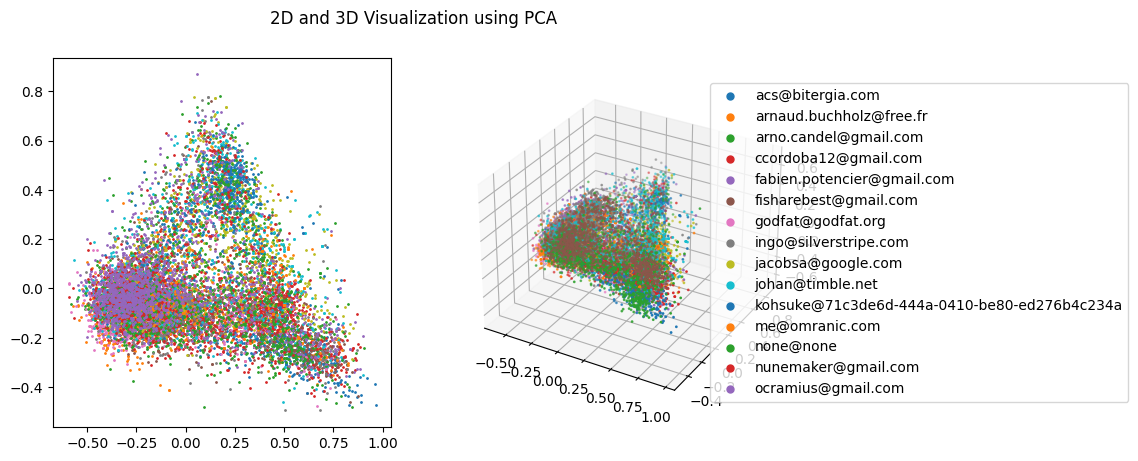

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

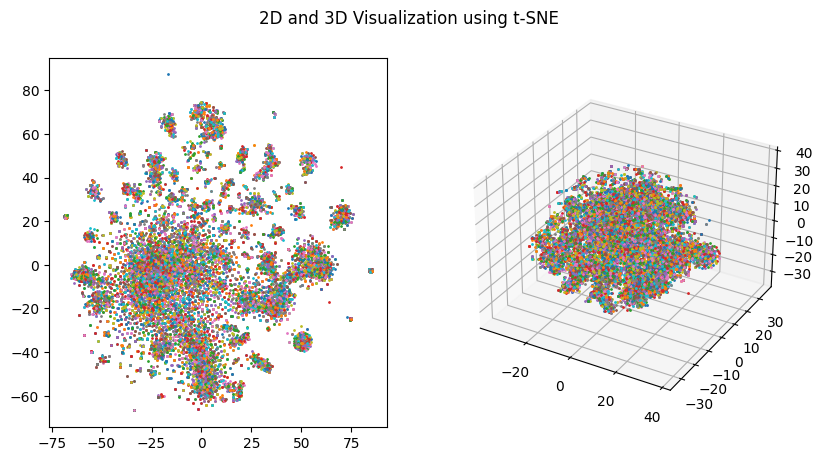

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data, legend = False)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 8
10 Most common:
[(0, 12579), (-1, 1829), (1, 41), (3, 24), (2, 22), (5, 18), (6, 14), (4, 9)]


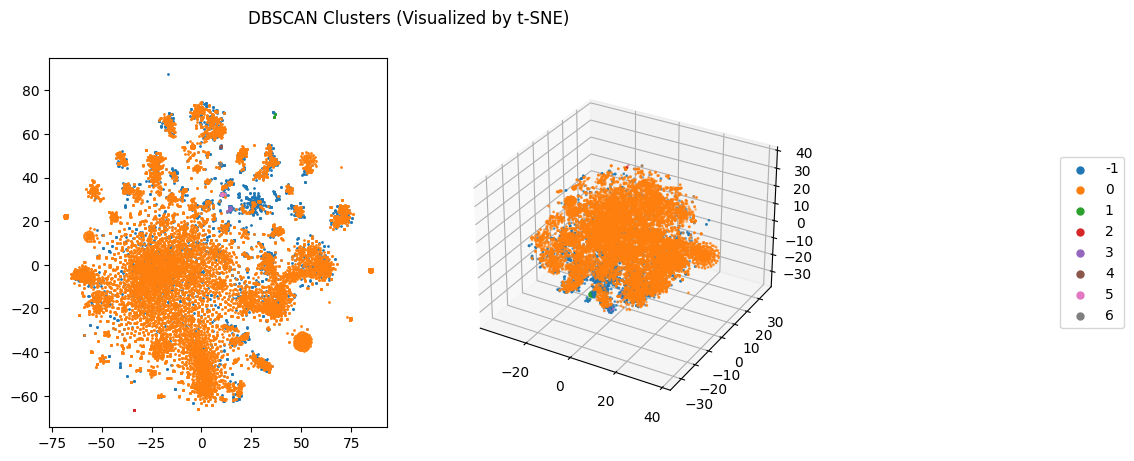

In [9]:
dbscan_model = DBSCAN(eps=0.7, min_samples=10)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 15 different authors.
There are 279 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,1829.0,15.0,113.0,"('none@none', 220)",144.0,2.0,"('fisharebest_webtrees', 203)"
1,12579.0,15.0,712.0,"('ccordoba12@gmail.com', 1806)",265.0,5.0,"('spyder-ide_spyder', 1632)"
2,41.0,2.0,20.5,"('acs@bitergia.com', 39)",9.0,2.0,"('chaoss_grimoirelab-perceval', 10)"
3,22.0,1.0,22.0,"('arnaud.buchholz@free.fr', 22)",1.0,22.0,"('ArnaudBuchholz_gpf-js', 22)"
4,24.0,4.0,2.5,"('nunemaker@gmail.com', 18)",10.0,1.0,"('jnunemaker_flipper', 7)"
5,9.0,1.0,9.0,('kohsuke@71c3de6d-444a-0410-be80-ed276b4c234a...,1.0,9.0,"('jenkinsci_jenkins', 9)"
6,18.0,3.0,3.0,"('none@none', 14)",5.0,3.0,"('wmdietl_jsr308-langtools', 10)"
7,14.0,6.0,1.0,"('nunemaker@gmail.com', 8)",7.0,1.0,"('jnunemaker_flipper', 7)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,1817.000000,5.875000,110.375000,55.250000,5.625000
std,4394.280568,5.866065,245.895848,97.685721,7.130167
min,9.000000,1.000000,1.000000,1.000000,1.000000
25%,17.000000,1.750000,2.875000,4.000000,1.750000
50%,23.000000,3.500000,14.750000,8.000000,2.500000
75%,488.000000,8.250000,44.750000,43.500000,6.000000
max,12579.000000,15.000000,712.000000,265.000000,22.000000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3,4,5,6,7
length_mean,76.904866,73.991255,27.951220,30.818182,46.333333,117.000000,93.833333,61.000000
length_std,55.826684,55.366549,1.125128,8.962733,16.747305,26.865922,42.630519,23.877664
n_uppercase_mean,4.264079,3.926226,1.975610,2.000000,1.541667,16.555556,5.000000,1.500000
n_uppercase_std,4.497825,4.316403,0.154257,0.000000,0.865022,4.245550,2.886751,0.906327
polarity_mean,0.012742,0.011419,0.000000,0.000000,0.034328,-0.002820,-0.013889,0.029978
polarity_std,0.185626,0.168601,0.000000,0.000000,0.164788,0.131257,0.117622,0.092437
subjectivity_mean,0.211185,0.190537,0.000000,0.000000,0.193716,0.182576,0.177469,0.170265
subjectivity_std,0.278345,0.273161,0.000000,0.000000,0.250908,0.104522,0.284074,0.303444


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Removed not used code (old use of pullrequests API).
___
2) 
[track_items] Check that upstream contributors file exists. If not, log it and return and
empty list of items.
___
3) 
[gerrit elk] Fixed dates in review before using them.
___
4) 
[Bugzilla SH Identities] Add email if we have this data.
___
5) 
Changed default self.max_items_bulk to <I> so it works in remote elastic cases.
___
6) 
[confluence][enrich] Support that username or displayName are not included in user data
___
7) 
[enrich][jenkins] Remove wrong log with the lines in the rename file
___
8) 
[mordred] Remove the general load of identities used during the initial step.
In mordred since <I> there is not an initial step anymore.
Identities are loaded before enrichment as usual.
___
9) 
[enrich][confluence] Add the new field content_url to the enrich index.

With this field the confluence page is known and it can be use for agg and filtering.
___
10) 
[panels] Add hype

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 15
10 Most common:
[(4, 4323), (5, 2904), (1, 1197), (14, 880), (3, 875), (6, 874), (8, 869), (0, 512), (9, 429), (12, 359)]


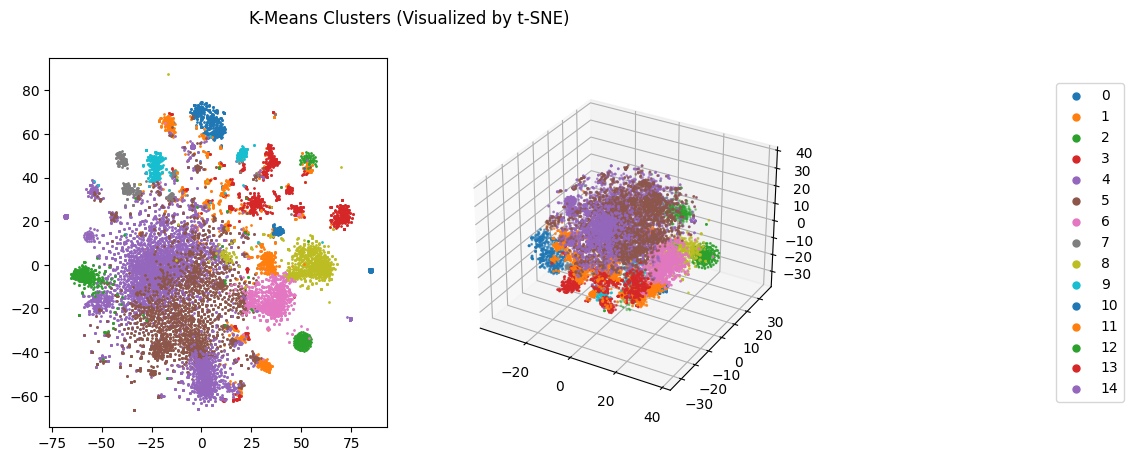

In [14]:
kmeans = KMeans(15)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [15]:
silhouette_score(vectors, kmeans_prediction)

0.07649971

In [16]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 15 different authors.
There are 279 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,512.0,11.0,3.0,"('acs@bitergia.com', 307)",18.0,2.5,"('chaoss_grimoirelab-elk', 245)"
1,1197.0,15.0,70.0,"('none@none', 196)",140.0,2.0,"('spyder-ide_spyder', 137)"
2,277.0,2.0,138.5,"('fabien.potencier@gmail.com', 276)",2.0,138.5,"('symfony_symfony', 276)"
3,875.0,15.0,51.0,"('fisharebest@gmail.com', 205)",109.0,2.0,"('fisharebest_webtrees', 205)"
4,4323.0,15.0,216.0,"('ccordoba12@gmail.com', 717)",174.0,3.0,"('spyder-ide_spyder', 640)"
5,2904.0,15.0,132.0,"('fabien.potencier@gmail.com', 608)",178.0,3.0,"('symfony_symfony', 481)"
6,874.0,15.0,48.0,('kohsuke@71c3de6d-444a-0410-be80-ed276b4c234a...,93.0,2.0,"('jenkinsci_jenkins', 248)"
7,319.0,12.0,7.0,"('ccordoba12@gmail.com', 175)",33.0,3.0,"('spyder-ide_spyder', 169)"
8,869.0,15.0,64.0,"('jacobsa@google.com', 133)",94.0,2.0,"('jenkinsci_jenkins', 90)"
9,429.0,13.0,3.0,"('ccordoba12@gmail.com', 338)",38.0,1.0,"('spyder-ide_spyder', 298)"


In [17]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,969.066667,13.066667,52.100000,79.333333,11.333333
std,1148.325269,3.348063,63.926911,55.713126,35.186070
min,165.000000,2.000000,3.000000,2.000000,1.000000
25%,304.500000,12.500000,6.000000,34.000000,2.000000
50%,512.000000,14.000000,22.000000,72.000000,2.000000
75%,877.500000,15.000000,67.000000,112.500000,3.000000
max,4323.000000,15.000000,216.000000,178.000000,138.500000


In [18]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
length_mean,96.289062,73.687552,29.794224,69.446857,70.076567,78.899105,85.854691,70.366771,63.472957,89.417249,32.866667,72.125475,68.690808,49.434483,96.534091
length_std,62.124453,55.287108,2.118571,47.711182,52.147147,56.625009,60.219721,52.203006,44.523233,56.184144,20.133353,45.941559,43.262645,36.052034,74.125960
n_uppercase_mean,3.568359,4.131997,2.534296,4.041143,3.608374,4.231405,4.556064,3.357367,3.551208,5.188811,1.854545,4.946768,2.080780,2.603448,5.951136
n_uppercase_std,4.256339,4.646137,1.325839,4.853337,3.745055,4.697037,4.770206,3.058090,3.542439,4.127261,2.402662,3.715784,2.825795,2.467301,6.185476
polarity_mean,-0.007181,0.006053,0.000000,-0.001180,0.013047,0.014461,0.028947,0.023973,0.020548,0.000559,0.005515,-0.002393,0.002645,0.004990,0.015073
polarity_std,0.192248,0.163610,0.000000,0.173647,0.174472,0.166278,0.190088,0.165073,0.165480,0.148662,0.082530,0.177403,0.197203,0.142083,0.181023
subjectivity_mean,0.226914,0.191629,0.000000,0.188595,0.190413,0.196640,0.226166,0.233455,0.161950,0.184286,0.063883,0.189802,0.236873,0.125179,0.245883
subjectivity_std,0.286786,0.258069,0.000000,0.264959,0.275750,0.267338,0.281530,0.288595,0.259946,0.264732,0.152470,0.260473,0.318576,0.267635,0.309108


In [19]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
[enrich][logs] Show datasource in loading identities logs to identify logs
when working with several data sources in different threads at the same time.
___
2) 
[enrich][bugzilla] Use items as the type for the ES index
___
3) 
[track_items] Check that upstream contributors file exists. If not, log it and return and
empty list of items.
___
4) 
[enrich][supybot] Add project support
___
5) 
[enrich][git] Manage not existing commits in github when getting author info
___
6) 
[enrich] Support old API when load identities from raw items (needed by track_items.py library)
___
7) 
[enrich][meetup] Fix to support empty events during comments extraction
___
8) 
[arthur] Remove the raw items from redis queue once they are processed
___
9) 
[config] Fix howto import the version from mordred
___
10) 
[enrich][jira] Include release field in enriched index
_________________

Number of messages in this class: 512
Most common author:
('acs@bitergia.c